**Topic:**        Project Benson   
**Subject:**      Explore MTA turnstile data  
**Date:**         07/03/2018  
**Name:**         Auste Mastaviciute  
**Worked with:**  Billy, Chelan, Alan, Joyce, Xu

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
from datetime import datetime as dt
import datetime
import dateutil.parser

In [18]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 15)
pd.set_option('display.precision', 3)

**Import Data from MTA website**

In [10]:
def fix_time(num):
    if len(str(num)) == 2:
        return str(num)
    else:
        return '0'+str(num)

def get_week_nums(month,yrs_back):
    week_list = []
    ref_date = datetime.date(2018,6,30)
    weeks_back = yrs_back * 52
    for i in range(weeks_back):
        week_shift = datetime.timedelta(-7 * i)
        new = ref_date + week_shift
        yr = str(new.year)[-2:]
        mt = fix_time(new.month)
        day = fix_time(new.day)
        string = yr + mt + day
        if int(mt) == month:
            week_list.append(int(string))
    return week_list

In [11]:
def scrape(week_nums):
    """Gets the data from MTA website and loads it into a pandas DataFrame"""
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = get_week_nums(6, 3)
turnstiles_df = scrape(week_nums)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066


**Data Formating**

In [12]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [13]:
#Trim the names of the columns from all the unneccesary white space
turnstiles_df.columns = turnstiles_df.columns.str.strip()
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [14]:
#Merge the DATE and TIME columns and format as DateTime rather than string
turnstiles_df['DATETIME'] = pd.to_datetime(turnstiles_df['DATE'] +' '+ turnstiles_df['TIME'], infer_datetime_format=True)


In [15]:
#Add WEEKDAY column
turnstiles_df['WEEKDAY'] = turnstiles_df['DATETIME'].dt.weekday_name
#turnstiles_df.head()


**Data Exploration & Cleaning**

In [16]:
#Check for duplicates
duplicate_check = turnstiles_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME']).EXITS.count().reset_index().sort_values(by='EXITS', ascending = False)
print(duplicate_check.head(5),'\n')
print('Need to remove duplicates')


         C/A  UNIT       SCP    STATION    WEEKDAY            DATETIME  EXITS
431549  H032  R295  00-05-00  WILSON AV   Thursday 2016-06-02 00:00:00      2
431557  H032  R295  00-05-00  WILSON AV   Thursday 2016-06-02 08:00:00      2
201442  B020  R263  00-06-01   AVENUE H     Monday 2016-05-30 12:00:00      2
431735  H032  R295  00-05-00  WILSON AV  Wednesday 2016-06-01 16:00:00      2
431739  H032  R295  00-05-00  WILSON AV  Wednesday 2016-06-01 20:00:00      2 

Need to remove duplicates stage


In [19]:
#Remove duplicates
turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME'], inplace = True, ascending = False)
turnstiles_df.drop_duplicates(subset = ['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME'], inplace = True)

#Check if duplicates are gone
turnstiles_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME']).EXITS.count().reset_index().sort_values(by='EXITS', ascending = False)


,C/A,UNIT,SCP,STATION,WEEKDAY,DATETIME,EXITS
0,A002,R051,02-00-00,59 ST,Friday,2016-06-03 00:00:00,1
1698635,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-26 20:00:00,1
1698628,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-19 16:00:00,1
1698629,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-19 20:00:00,1
1698630,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-26 00:00:00,1
1698631,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-26 04:00:00,1
1698632,R147,R033,04-00-03,TIMES SQ-42 ST,Tuesday,2018-06-26 08:00:00,1
...,...,...,...,...,...,...,...
849316,N139,R355,00-00-00,111 ST,Thursday,2017-06-01 05:00:00,1
849317,N139,R355,00-00-00,111 ST,Thursday,2017-06-01 09:00:00,1


STATION
34 ST-PENN STA     53530
FULTON ST          52604
23 ST              38708
GRD CNTRL-42 ST    35133
CANAL ST           32089
34 ST-HERALD SQ    29583
CHAMBERS ST        29530
                   ...  
VAN SICLEN AVE      1623
JUNIUS ST           1562
NASSAU ST           1547
NORWOOD AV          1544
PENNSYLVANIA AV     1508
SUTTER AV           1097
CLEVELAND ST        1092
Name: EXITS, Length: 380, dtype: int64

Preferably, should remove the values with non-exact hour times (where min:sec is not 00:00)


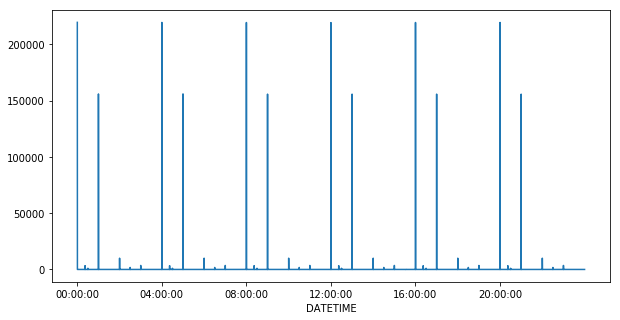

In [37]:
#Understand the distribution among different times
time_dist = turnstiles_df.groupby([turnstiles_df['DATETIME'].dt.time])['EXITS'].count().sort_values(ascending=False)
time_dist.plot(figsize = (10, 5), xticks = ['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00'])
print('Preferably, should remove the values with non-exact hour times (where min:sec is not 00:00)')

In [ ]:
#Remove timestamps with non-zero minutes and seconds




In [32]:
#Sort the data frame by DATETIME column
turnstiles_df = turnstiles_df.sort_values(by = ['C/A', 'UNIT', 'SCP', 'STATION', 'DATETIME'])
#turnstiles_df.head(15)

#Add two new columns with Previous Datetime a record was taken and the actual record in PREV_EXITS
turnstiles_df['PREV_DATETIME'] = turnstiles_df['DATETIME'].shift()
turnstiles_df['PREV_EXITS'] = turnstiles_df['EXITS'].shift()
#turnstiles_df.head()

#Add EXITS_DIFF column - Transform the Exits column from accummulative to actual per time period
turnstiles_df['EXITS_DIFF'] = turnstiles_df['EXITS'].sub(turnstiles_df['PREV_EXITS'])
#turnstiles_df

#Add TIME_DIFF column to evaluate how frequently the records are being taken
turnstiles_df['TIME_DIFF'] = turnstiles_df['DATETIME'].sub(turnstiles_df['PREV_DATETIME'])
#turnstiles_df.head()

**More formatting**

In [ ]:
#Explore the distribution of EXITS_DIFF column
exits_diff = sorted(list(turnstiles_df['EXITS_DIFF'].values))
#print(exits_diff[:10])
#print(exits_diff[-10:])


#Remove rows with NaN values in previous exits column
turnstiles_df.dropna(axis = 0, inplace = True)
turnstiles_df.head()


**More cleaning**

In [ ]:
#Handle negative or extreme EXITS_DIFF values



In [41]:
#Shorten the data frame
turnstile_short = turnstiles_df[['STATION', 'WEEKDAY','DATETIME', 'EXITS_DIFF', 'TIME_DIFF']]
turnstile_short.loc[turnstile_short['STATION'] == '111 ST'].head(10)

In [49]:
import re

#Remove non-New York stations (start with PTH)
turnstile_short.loc[turnstile_short['STATION'] == r'PTH+'].head(10)

#turnstile_short.groupby(['STATION'])['EXITS'].count().sort_values(ascending = False)

,STATION,WEEKDAY,DATETIME,EXITS_DIFF,TIME_DIFF
